In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

The filenames have the plant names so let us create a dataframe mapping the category to a numeric class label.

In [47]:
files = np.sort(glob.glob('../fedfarm/train/*/*png'))
labels = [f.split('/')[-2] for f in files]
names = np.sort(np.unique(labels))
label_df = pd.DataFrame({'category': names, 'label': np.arange(len(names))})
label_df

category  label
0                 Black-grass      0
1                    Charlock      1
2                    Cleavers      2
3            Common Chickweed      3
4                Common wheat      4
5                     Fat Hen      5
6            Loose Silky-bent      6
7                       Maize      7
8           Scentless Mayweed      8
9             Shepherds Purse      9
10  Small-flowered Cranesbill     10
11                 Sugar beet     11

Let us look at the data distribution. For complete fairness we should do this for a training set only but as we are going to make a random split the distribution will be the same for training and validation.

In [48]:
files_df = pd.DataFrame({'filename': files, 'category': labels})
files_df = pd.merge(files_df, label_df, on=['category'], how='left')
files_df.category.value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
Name: category, dtype: int64

The dataset is unbalanced but not massively.

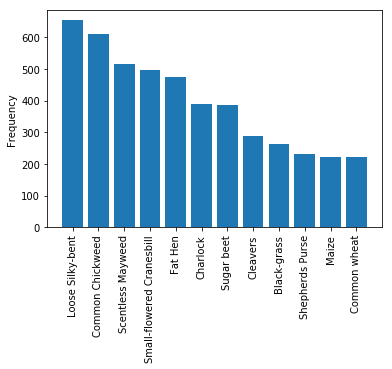

In [49]:
fig, ax = plt.subplots(1)
ax.bar(np.arange(12), files_df.category.value_counts())
ax.set_xticks(np.arange(12));
ax.set_xticklabels(files_df.category.value_counts().index.values, rotation=90);
ax.set_ylabel('Frequency');

Let us look at some of the images.

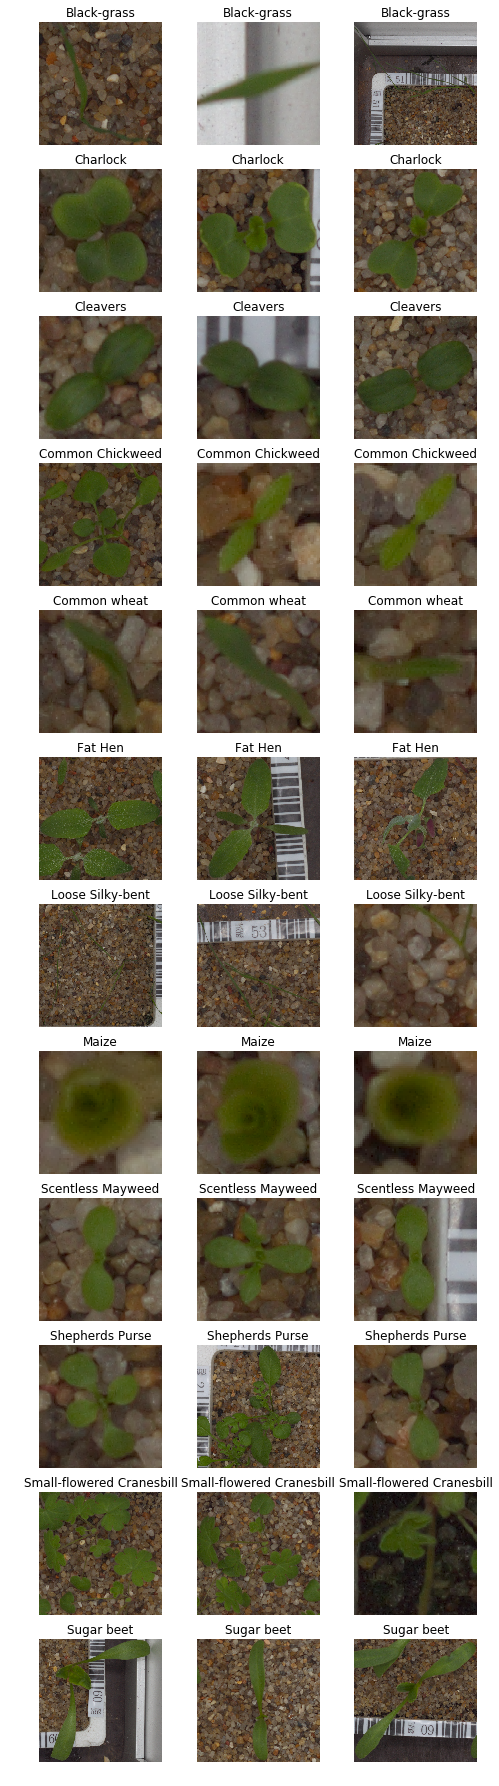

In [330]:
fig, axes = plt.subplots(12, 3)
fig.set_figheight(32)
fig.set_figwidth(8)
for i, name in enumerate(names):
    f = files_df[files_df.category == name].sample(3).filename.values
    for j in range(3):
        axes[i][j].imshow(plt.imread(f[j]))
        axes[i][j].axis('off')
        axes[i][j].set_title(name)

Here we taken 4000 examples for training, keeping the rest for validation and divided these into 10 shards each with 400 examples. In contrast to the original paper these would not be iid shards since the dataset (unlike MNIST) is unbalanced so it is more accurate to describe the shards as representative of the class distribution rather than IID (although I have named the columns iid/non-iid to keep in line with the paper). 

In [ ]:
train, val = np.split(np.random.permutation(4750), [4000])
train_df = files_df.loc[train].sort_values(by='category')
val_df = files_df.loc[val]

In [335]:
n_shards = 10
shards_iid = np.random.permutation(np.tile(np.arange(n_shards), 400))
len(shards_iid)

4000

For the non-iid shards, to place images in shards so that just a few classes are in each shard, each shard indices are repeated to get a pair of arrays per shard of length 200. Then the arrays are shuffled resulting in 20 arrays, concatenated and assigned to the examples which have been sorted. 

In [ ]:
# [[0, ..., 0], ..., [9, ..., 9], [0, ..., 0], ..., [9, ..., 9]]
shards_non_iid = np.tile(np.tile(np.arange(n_shards)[:, None], [1, 200]), [2, 1])
shards_non_iid = np.concatenate(np.random.permutation(shards_non_iid))

In [336]:
train_df['shard_iid'] = shards_iid
train_df['shard_non_iid'] = shards_non_iid

Only a few classes per non_iid shard which leads to class distributions in each shard that are very different from the data distribution. 

In [337]:
train_df.groupby('shard_non_iid', as_index=False).category.agg(lambda x: len(x.category.unique())).rename(columns={'category': 'num_categories'})

shard_non_iid  num_categories
0              0               3
1              1               3
2              2               3
3              3               2
4              4               3
5              5               4
6              6               3
7              7               2
8              8               3
9              9               4

In [74]:
td = pd.read_csv('train_resized.csv')
groups = td.groupby('shard_non_iid').groups

These shards are not evenly balanced either for the most part.

In [124]:
for k, v in groups.items():
    df = ( pd.DataFrame(td.loc[v]).label.value_counts().reset_index().rename(
     columns={'index': 'label', 'label': 'count'}))
    print('shard', k)
    print('label {}'.format(' '.join(map('{:3d}'.format, df.label.values) )))
    print('count {}'.format(' '.join(map('{:3d}'.format, df['count'].values) )))
    print()

shard 0
label   6  10   9
count 200 128  72

shard 1
label   0   6   5
count 200 101  99

shard 2
label   3   7   6
count 200 149  51

shard 3
label  10   8
count 200 200

shard 4
label   5   2   3
count 200 183  17

shard 5
label  11   3   4  10
count 121 111  89  79

shard 6
label   1   2   0
count 330  57  13

shard 7
label   6   3
count 200 200

shard 8
label  11   8   7
count 200 163  37

shard 9
label   9   4   5   8
count 122 101  99  78



label  count
0      9    122
1      4    101
2      5     99
3      8     78

In [338]:
train_df.groupby('shard_iid', as_index=False).category.agg(lambda x: len(x.category.unique())).rename(columns={'category': 'num_categories'})

shard_iid  num_categories
0          0              12
1          1              12
2          2              12
3          3              12
4          4              12
5          5              12
6          6              12
7          7              12
8          8              12
9          9              12

In [339]:
# train_df.to_csv('seedlings_train.csv')
# val_df.to_csv('seedlings_val.csv')

In [7]:
len(files)

4750

In [ ]:
heights, widths, channels = zip(*list(map(plt.imread, files)))

In [52]:
shapes = pd.read_csv('train_resized.csv')['shape'].values

In [54]:
height, width, channels = zip(*map(eval, shapes))

# Input pipeline

The image dimensions vary quite a lot but the aspect ratio is 1:1 for almost all of them. I resized all the images to be $256 \times 256$. 

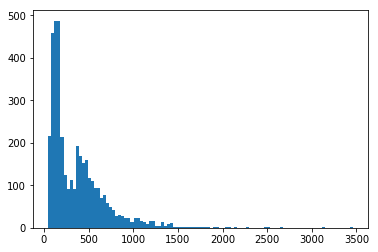

In [57]:
plt.hist(height, bins=100);

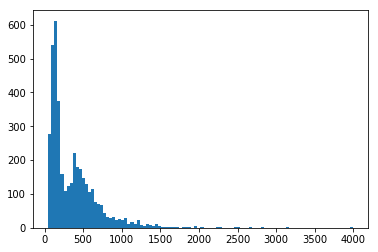

In [58]:
plt.hist(width, bins=100);

In [68]:
from collections import Counter
aspect_ratio_counts = Counter(np.divide(height, width))
aspect_ratio_counts.most_common(10)

[(1.0, 3937),
 (1.0600315955766193, 13),
 (0.9129353233830846, 3),
 (0.9994853319608852, 3),
 (0.9547244094488189, 3),
 (0.9, 2),
 (0.9413886384129847, 2),
 (0.9990059642147118, 1),
 (0.9992972593113141, 1),
 (1.0454545454545454, 1)]

A few images seem to be in the RGBA format so we will explicitly select only the first 3 channels when loading in the data.

In [73]:
channel_counts = Counter(channels)
channel_counts

Counter({3: 3978, 4: 22})

Visual inspection suggests that the quality does not seem to be affected too much by resizing.

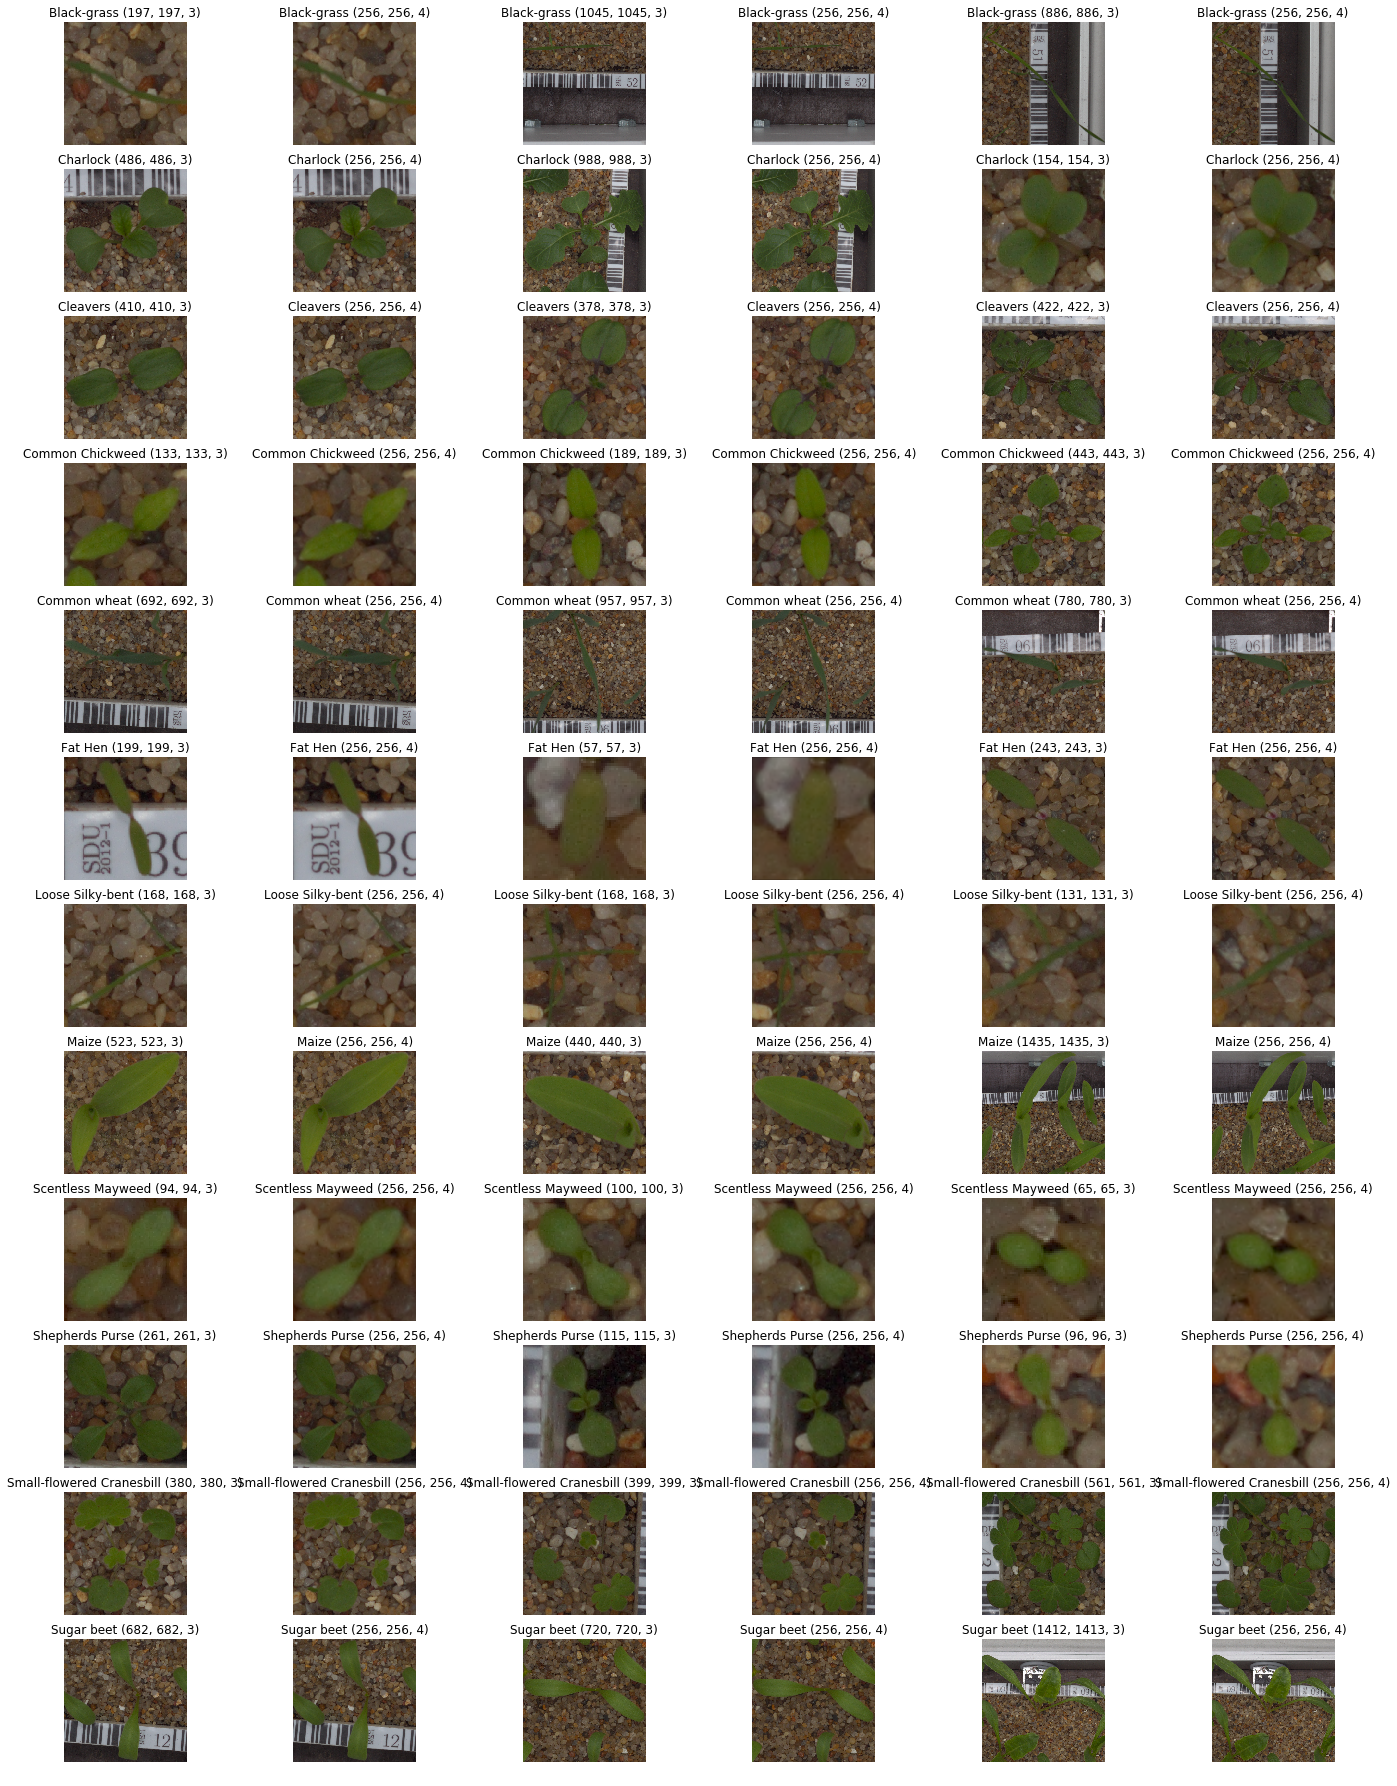

In [70]:
resized_df = pd.read_csv('train_resized.csv')
n = 3
fig, axes = plt.subplots(12, n*2, figsize=(24, 32))
for i, name in enumerate(names):
    f = resized_df[resized_df.category == name].sample(n).filename.values
    for j in range(0, n*2, 2):
        fns = [f[j//2].replace('train_256x256x3', 'train'), f[j//2]]
        for jj, fn in zip(range(j, j+2), fns):
            im = plt.imread(fn)
            axes[i][jj].imshow(im)
            axes[i][jj].axis('off')
            axes[i][jj].set_title(name + ' ' + str(im.shape))